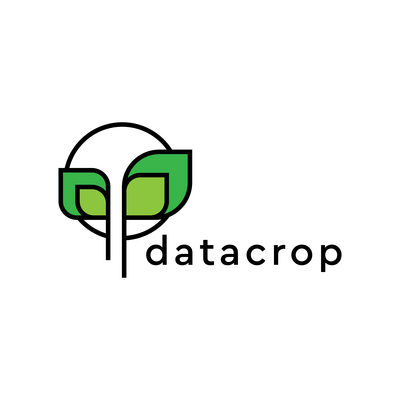





# TÉCNICAS DE SCRAPING APLICADAS PARA ENRIQUECER LOS DATOS Y OBTENER NUEVAS FUENTES PARA EL RETO.


Para realizar scraping se ha usado la libreria selenium a través de las etiquetas XPATH y wget para descargar los informes coyunturales


## El código se divide en tres partes:

### - 1. Setup y preparación de la libreria Selenium:

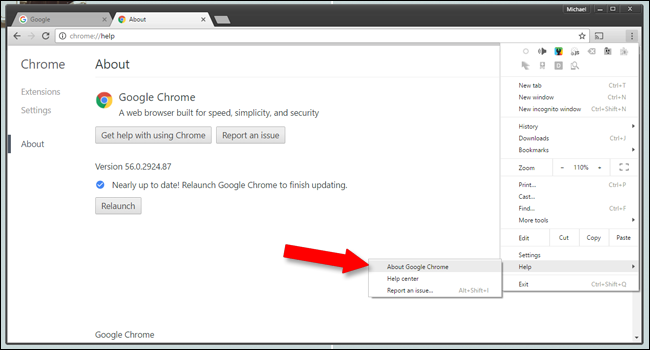


Necesitamos saber la versión de chrome que tenemos para descarganos el chrome driver correcto para ejecutar selenium que debe de descargar aqui https://chromedriver.chromium.org/downloads . Se descargará la versión correspondiente con la que hemos comprobado en chrome y se descargará. Encontraremos un archivo que descomprimir donde dentro se aloja el "Chromedriver.exe" lo deberemos de dejar en el mismo path donde se encuentre este jupyter notebook.


Ejecutar en nuestra consola de Anaconda Prompt / CMD el siguiente comando: pip install selenium


### - 2. Ejecución de la extracción de informes coyunturales con wget y selenium:

Simplemente deberemos ejecutar en nuestra consola de Anaconda Prompt / CMD el siguiente comando: pip install wget


### - 3. Ejecución de la extracción de datos de consumo del MAPA 2013-2020:

 Primero se encuentra un código generador de URLS a procesar iterando sobre el numero de periodos y el tipo de producto a extraer (Hortalizas o frutas) además de despues recorrer todas estas url con selenium scrapeando las tablas del MAPA y guardando y etiquetando los datos en un Pandas Dataframe para su posterior guardado en CSV.



In [ ]:
### Selenium Set-up
from selenium import webdriver
from selenium.webdriver.support.ui import Select, WebDriverWait
import pandas as pd
pd.options.mode.chained_assignment = None
import time
import wget

#El driver es el navegador brave basado en el motor chromium (editar para probar)

### indicamos el path al lugar donde se encuentra el "chromedriver.exe"

driver_path = "C:/Users/Sergio/Desktop/scrapper_dcrop/chromedriver.exe" ## Ejemplo

## indicamos el path donde se encuentra instalado nuestro google chrome indicando el archivo "chrome.exe"

chrome_path = "C:\Program Files\Google\Chrome\Application\chrome.exe" ## Ejemplo

option = webdriver.ChromeOptions()
option.binary_location = chrome_path
#option.add_argument("--incognito") OPCIONAL abrir sesion de selenium en modo incognito
#option.add_argument("--headless") 

# Creamos una nueva instancia de Selenium y se deberá abrir una nueva ventana de Chrome
browser = webdriver.Chrome(executable_path=driver_path, options=option)

## Scraping variacion de precios F&H semanal

In [ ]:
## Scraper informes coyunturales 

# Link a los informes conyuturales para crear un dataset con la variacion de precios de F&H semanalmente

url2 = 'https://www.mapa.gob.es/es/estadistica/temas/publicaciones/informe-semanal-coyuntura/2020.aspx' 

browser.get(url2)

# Para guardar los links
links = []
# Bucle para obtener los links de la pagina que descargan los archivos semanales
for i in range(2,107,2):
    element = browser.find_element_by_xpath('//*[@id="main"]/div/div[2]/div[2]/div/div/div/div/div/ul/li['+str(i)+']/a')
    href = element.get_attribute('href')
    links.append(href)
    
 # iteramos sobre la lista de links para descargar los archivos con wget   
# for href in links:
#     wget.download(href)
#     time.sleep(3)

## Scraping con Selenium para obtener toda la serie historica de consumo de F&H en el MAPA 2013-2020

### Scraping Hortalizas MAPA

In [ ]:
# Preprocesado de etiquetas necesarias para sacar el consumo de hortalizas
# Entramos en la web a scrapear
browser.get('https://www.mapa.gob.es/app/consumo-en-hogares/resultado.asp?CCAA=1&AA=11&periodo=1&grupo=16')

# se saca la etiqueta que contiene un menú desplegable con las diferentes comunidades autonomas
select = browser.find_element_by_xpath("/html/body/div[2]/div/div/div[2]/div/div[2]/div/form/fieldset/p[1]/select")          
options = select.find_elements_by_tag_name("option") # se obtiene las diferentes opciones del menú desplegable

optionsList = []
optionsPeriod = list(range(1,91,1))

## se le asigna un valor a cada comunidad para luego poder iterar sobre estos y sacar de manera automatica
#los datos por comunidad
for option in options: 
    optionsList.append(option.get_attribute("value"))
    
optionsList.pop(0)

lista_url= []
## se construye la url teniendo en cuenta el periodo (90 semanas a Scrapear) y la comunidad autonoma 
#y se guardan los links definitivos en una lista
for optionValue in optionsList:
    url = 'https://www.mapa.gob.es/app/consumo-en-hogares/resultado.asp?CCAA='+str(optionValue)
    for optionPeriod in optionsPeriod:
        url2 = url+'&AA=11&periodo='+str(optionPeriod)+'&grupo=16'
        lista_url.append(url2)

In [ ]:
#Este codigo se recorre los links generados, los abre con selenium, scrapea las etiquetas y la tabla de datos y los guarda en un csv
start_loop = time.time()
for url in lista_url:
    browser.get(url)
    time.sleep(3)
    for optionPeriod in optionsPeriod:
        time.sleep(2)
        try:
            fecha = browser.find_element_by_xpath("/html/body/div[2]/div/div/div[2]/div/div[2]/div/div[10]/div/strong[2]").text
            ccaa_scrap = browser.find_element_by_xpath("/html/body/div[2]/div/div/div[2]/div/div[2]/div/div[8]/div/strong[2]").text
            tables = pd.read_html(url)
            df =tables[1]
            new_header = df.iloc[0] 
            df = df[1:] 
            df.columns = new_header
            df['CCAA'] = ccaa_scrap
            df['Fecha'] = fecha
            df['Año'] = df['Fecha'].str[0:5]
            df['Mes'] = df['Fecha'].str[7:]
            df.drop(columns=['Fecha'],inplace=True)
            df.to_csv(''+ccaa_scrap+'_hortalizas_'+str(fecha)+'.csv', index= False, encoding= 'utf-8-sig')
            print("Se ha terminado de scrapear {} en el periodo {}".format(ccaa_scrap,fecha))
            break
        except:
            print("¡No se puedo extraer la fecha!")
            break
        
end_loop = time.time()

print("¡Se ha Scrapeado todos los datos de consumo de hortalizas satisfactoriamente en {} horas!".format(((end_loop - start_loop)/60)/60))

### Scraping frutas frescas MAPA

In [ ]:
# Preprocesado de etiquetas necesarias para sacar el consumo de hortalizas
# Entramos en la web a scrapear
browser.get('https://www.mapa.gob.es/app/consumo-en-hogares/resultado.asp?CCAA=1&AA=11&periodo=1&grupo=17')

# se saca la etiqueta que contiene un menú desplegable con las diferentes comunidades autonomas
select = browser.find_element_by_xpath("/html/body/div[2]/div/div/div[2]/div/div[2]/div/form/fieldset/p[1]/select")          
options = select.find_elements_by_tag_name("option") # se obtiene las diferentes opciones del menú desplegable

optionsList = []
optionsPeriod = list(range(1,91,1))

## se le asigna un valor a cada comunidad para luego poder iterar sobre estos y sacar de manera automatica
#los datos por comunidad
for option in options: 
    optionsList.append(option.get_attribute("value"))
    
optionsList.pop(0)

lista_url= []
## se construye la url teniendo en cuenta el periodo (90 semanas a Scrapear) y la comunidad autonoma 
#y se guardan los links definitivos en una lista
for optionValue in optionsList:
    url = 'https://www.mapa.gob.es/app/consumo-en-hogares/resultado.asp?CCAA='+str(optionValue)
    for optionPeriod in optionsPeriod:
        url2 = url+'&AA=11&periodo='+str(optionPeriod)+'&grupo=17'
        lista_url.append(url2)

In [ ]:
#Scraping frutas frescas
start_loop = time.time()
for url in lista_url:
    browser.get(url)
    time.sleep(4)
    for optionPeriod in optionsPeriod:
        time.sleep(3)
        try:
            fecha = browser.find_element_by_xpath("/html/body/div[2]/div/div/div[2]/div/div[2]/div/div[10]/div/strong[2]").text
            ccaa_scrap = browser.find_element_by_xpath("/html/body/div[2]/div/div/div[2]/div/div[2]/div/div[8]/div/strong[2]").text
            tables = pd.read_html(url)
            df =tables[1]
            new_header = df.iloc[0] 
            df = df[1:] 
            df.columns = new_header
            df['CCAA'] = ccaa_scrap
            df['Fecha'] = fecha
            df['Año'] = df['Fecha'].str[0:5]
            df['Mes'] = df['Fecha'].str[7:]
            df.drop(columns=['Fecha'],inplace=True)
            df.to_csv(''+ccaa_scrap+'_frutas_'+str(fecha)+'.csv', index= False, encoding= 'utf-8-sig')
            print("Se ha terminado de scrapear {} en el periodo {}".format(ccaa_scrap,fecha))
            break
        except:
            print("¡No se puedo extraer el periodo! {}".format(url))
            break
        
end_loop = time.time()

print("¡Se ha Scrapeado todos los datos de consumo de frutas satisfactoriamente en {} horas!".format(((end_loop - start_loop)/60)/60))
    

## Scraping por Hortalizas por Canal de Venta (Hipermercado, Internet, Supermercado)

In [ ]:
### Hipermercados, Supermercados y Internet
# Preprocesado de etiquetas necesarias para sacar las hortalizas
# Entramos en la web a scrapear

browser.get('https://www.mapa.gob.es/app/consumo-en-hogares/resultadoes.asp?lugar=105&AA=11&periodo=1&grupo=16')

optionsVenta = [105,104,123]

optionsPeriod = list(range(1,91,1))

## se le asigna un valor a cada comunidad para luego poder iterar sobre estos y sacar de manera automaticá 
#los datos por comunidad

lista_url= []
## se construye la url teniendo en cuenta el periodo (90 semanas a Scrapear) y la comunidad autonoma 
#y se guardan los links definitivos en una lista
for optionVenta in optionsVenta:
    url = 'https://www.mapa.gob.es/app/consumo-en-hogares/resultadoes.asp?lugar='+str(optionVenta)
    for optionPeriod in optionsPeriod:
        url2 = url+'&AA=11&periodo='+str(optionPeriod)+'&grupo=16'
        lista_url.append(url2)

In [ ]:
start_loop = time.time()
counter = 0
#Nos reccoremos la lista de urls generadas
for url in lista_url:
    browser.get(url)
    fecha = browser.find_element_by_xpath('//*[@id="app_section"]/div[10]/div/strong[2]').text
    canal_scrap = browser.find_element_by_xpath("/html/body/div[2]/div/div/div[2]/div/div[2]/div/div[8]/div/strong[2]").text
    if canal_scrap == 'SUPER/AUTOS/G.ALM.':
        canal_scrap = 'SUPERMERCADO'
    else:
        pass
    time.sleep(3)
    #Nos recorremos los periodos correspondientes a los 7 años para que vaya iterando correctamente
    for optionPeriod in optionsPeriod:
        try:
            time.sleep(2)
            # Se sacan las etiquetas de fecha y comunidad autonoma para luego ser agregadas al dataframe resultante
            tables = pd.read_html(url)
            # Limpiamos el header y usamos el primer row como header, ya que es el más descriptivo
            df =tables[1]
            new_header = df.iloc[0] 
            df = df[1:] 
            df.columns = new_header
            # se agregan al dataframe las etiquetas mencionadas
            df['Canal_Venta'] = canal_scrap
            df['Fecha'] = fecha
            df['Año'] = df['Fecha'].str[0:5]
            df['Mes'] = df['Fecha'].str[7:]
            df.drop(columns=['Fecha'],inplace=True)
            df.to_csv(''+canal_scrap+'_ventas_'+str(fecha)+'.csv', index= False, encoding= 'utf-8-sig')
            counter += 1
            print("Iteraccion: {} . Se ha terminado de scrapear {} en el periodo {}".format(counter,canal_scrap,fecha))
            break
        except:
            print("¡No se puedo extraer el periodo! {}".format(url))
            break
        
end_loop = time.time()

print("¡Se ha Scrapeado todos los datos de consumo satisfactoriamente en {} minutos!".format((end_loop - start_loop)/60/60))

## Scraping Frutas por Canal de Venta (Hipermercado, Internet, Supermercado)

In [ ]:
### Hipermercados, Supermercados y Internet
# Preprocesado de etiquetas necesarias para sacar las hortalizas
# Entramos en la web a scrapear

browser.get('https://www.mapa.gob.es/app/consumo-en-hogares/resultadoes.asp?lugar=105&AA=11&periodo=1&grupo=17')

optionsVenta = [105,104,123]

optionsPeriod = list(range(1,91,1))

## se le asigna un valor a cada comunidad para luego poder iterar sobre estos y sacar de manera automaticá 
#los datos por comunidad

lista_url= []
## se construye la url teniendo en cuenta el periodo (90 semanas a Scrapear) y la comunidad autonoma 
#y se guardan los links definitivos en una lista
for optionVenta in optionsVenta:
    url = 'https://www.mapa.gob.es/app/consumo-en-hogares/resultadoes.asp?lugar='+str(optionVenta)
    for optionPeriod in optionsPeriod:
        url2 = url+'&AA=11&periodo='+str(optionPeriod)+'&grupo=17'
        lista_url.append(url2)

In [ ]:
start_loop = time.time()
counter = 0
#Nos reccoremos la lista de urls generadas
for url in lista_url:
    browser.get(url)
    fecha = browser.find_element_by_xpath('//*[@id="app_section"]/div[10]/div/strong[2]').text
    canal_scrap = browser.find_element_by_xpath("/html/body/div[2]/div/div/div[2]/div/div[2]/div/div[8]/div/strong[2]").text
    if canal_scrap == 'SUPER/AUTOS/G.ALM.':
        canal_scrap = 'SUPERMERCADO'
    else:
        pass
    time.sleep(3)
    #Nos recorremos los periodos correspondientes a los 7 años para que vaya iterando correctamente
    for optionPeriod in optionsPeriod:
        try:
            time.sleep(2)
            # Se sacan las etiquetas de fecha y comunidad autonoma para luego ser agregadas al dataframe resultante
            tables = pd.read_html(url)
            # Limpiamos el header y usamos el primer row como header, ya que es el más descriptivo
            df =tables[1]
            new_header = df.iloc[0] 
            df = df[1:] 
            df.columns = new_header
            # se agregan al dataframe las etiquetas mencionadas
            df['Canal_Venta'] = canal_scrap
            df['Fecha'] = fecha
            df['Año'] = df['Fecha'].str[0:5]
            df['Mes'] = df['Fecha'].str[7:]
            df.drop(columns=['Fecha'],inplace=True)
            df.to_csv(''+canal_scrap+'_ventas_'+str(fecha)+'.csv', index= False, encoding= 'utf-8-sig')
            counter += 1
            print("Iteraccion: {} . Se ha terminado de scrapear {} en el periodo {}".format(counter,canal_scrap,fecha))
            break
        except:
            print("¡No se puedo extraer la fecha! {}".format(url))
            break
        
end_loop = time.time()

print("¡Se ha Scrapeado todos los datos de consumo satisfactoriamente en {} minutos!".format((end_loop - start_loop)/60/60))